# Exploration of k3d usage for discretisedfield visualisation

In [1]:
import k3d
import matplotlib
import numpy as np
import discretisedfield as df
%matplotlib inline

## Mesh and field objects to be visualised

Mesh has dimensions 10 x 6 x 4 to accommodate an ellipsoid

$$\frac{x^2}{a^2} + \frac{y^2}{b^2} + \frac{z^2}{c^2} <= 1$$

with: $a=5$, $b=3$, and $c=2$. The space is discretised into cells with dimensions $(1, 1, 1)$.

In [2]:
a, b, c = 5, 3, 2

mesh =  df.Mesh(p1=(-a, -b, -c), p2=(a, b, c), cell=(0.5, 0.5, 0.5))

We define the ellipsoid geometry by specifying the norm function, which returns 0 outside the sample.

In [15]:
def norm_fun(pos):
    x, y, z = pos
    if (x/a)**2 + (y/b)**2 + (z/c)**2 <= 1:
        return 0.5
    else:
        return 0
    
def value_fun(pos):
    x, y, z = pos
    if x >= 0:
        return (x*y, x*z, y*z)
    else:
        return (1, 1, 1)

field = df.Field(mesh, value=value_fun, norm=norm_fun)

The plot of a slice in the $z$ direction:

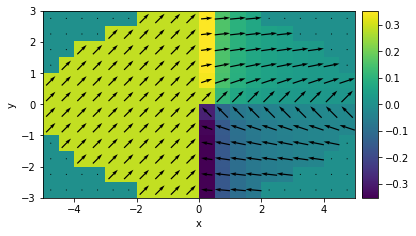

In [16]:
field.plot_plane("z")

## Mesh and domain visualisation

There are two different way how we can visualise the mesh:

1. Showing the entire (cubic) domain and give impression of the discretisation by using different colours. All the information for plotting can be obtained from the `mesh` object.

In [17]:
def k3d_vox(plot_array, k3d_plot=None, colormap=[0x99bbff, 0xff4d4d], **kwargs):
    plot_array = plot_array.astype(np.uint8)  # to avoid the warning

    xmin, ymin, zmin = mesh.pmin
    xmax, ymax, zmax = mesh.pmax

    if k3d_plot is None:
        k3d_plot = k3d.plot()
        k3d_plot.display()
    k3d_plot += k3d.voxels(plot_array,
                           color_map=colormap,
                           xmin=xmin, xmax=xmax,
                           ymin=ymin, ymax=ymax,
                           zmin=zmin, zmax=zmax,
                           outlines=False,
                           **kwargs)

def k3d_mesh(mesh, k3d_plot=None, **kwargs):
    plot_array = np.ones(tuple(reversed((mesh.n))))
    plot_array[0, 0, -1] = 2  # mark the discretisation cell
    k3d_vox(plot_array, k3d_plot=k3d_plot, **kwargs)

k3d_mesh(mesh)

Output()

2. Showing only a part of the mesh where norm is not zero (where the material is present). For this `field` object must be used. This can be achieved either by plotting one of the components (e.g. `field.x`) or `field.norm`.

In [18]:
def k3d_domain(field, k3d_plot=None, **kwargs):
    plot_array = np.squeeze(field.norm.array)
    plot_array = np.swapaxes(plot_array, 0, 2) # in k3d, numpy arrays are (z, y, x)
    plot_array[plot_array != 0] = 1  # make all domain cells to have the same colour
    k3d_vox(plot_array, k3d_plot=k3d_plot, **kwargs)

k3d_domain(field)

Output()

## Coordinates

It is not clear for what exactly showing the cell centres can be useful at the end but it can be useful for checking and testing of the vector field plotting. There are two possible options:

1. Plotting all cell centres using `mesh` object.

In [19]:
def k3d_points(plot_array, k3d_plot=None, point_size=0.15, color=0x99bbff, **kwargs):
    plot_array = plot_array.astype(np.float32)  # to avoid the warning
    
    if k3d_plot is None:
        k3d_plot = k3d.plot()
        k3d_plot.display()
    k3d_plot += k3d.points(plot_array, point_size=point_size, color=color, **kwargs)


def k3d_mesh_coordinates(mesh, k3d_plot=None, **kwargs):
    plot_array = np.array(list(mesh.coordinates))
    k3d_points(plot_array, k3d_plot=k3d_plot, **kwargs)
        
k3d_mesh_coordinates(mesh)

Output()

2. Plotting only the cell centres where norm is not zero (where the material is present).

In [20]:
def k3d_domain_coordinates(field, k3d_plot=None, **kwargs):
    plot_array = np.array([i for i in field.mesh.coordinates if field.norm(i) > 0])  # this can use np.fromiter
    k3d_points(plot_array, k3d_plot=k3d_plot, **kwargs)
        
k3d_domain_coordinates(field)

Output()

## Vector field

In [21]:
cmap = matplotlib.cm.get_cmap('viridis')
cmap(1)

(0.26851, 0.009605, 0.335427, 1.0)

In [24]:
def k3d_vector(field, k3d_plot=None):
    # Plot arrows only with norm > 0.
    data = [(i, field(i)) for i in field.mesh.coordinates if field.norm(i) > 0]
    coordinates, vectors = zip(*data)
    coordinates, vectors = np.array(coordinates), np.array(vectors)

    # Middle of the arrow at the cell centre.
    coordinates -= 0.5*vectors
    
    # To avoid the warning
    coordinates = coordinates.astype(np.float32)
    vectors = vectors.astype(np.float32)

    cmap = matplotlib.cm.get_cmap('viridis', 256)
    
    vc = vectors[..., 0]
    vc = np.interp(vc, (vc.min(), vc.max()), (0, 1))
    colors = cmap(vc)
    colors = [int('0x{}'.format(matplotlib.colors.to_hex(rgb)[1:]), 16) for rgb in colors]
    colors = list(zip(colors, colors))
    
    if k3d_plot is None:
        k3d_plot = k3d.plot()
        k3d_plot.display()
    k3d_domain_coordinates(field, k3d_plot=k3d_plot)
    k3d_plot += k3d.vectors(coordinates, vectors, colors=colors)
    

k3d_vector(field)

Output()

**Questions**:

1. How to add the colorbar?
2. Can we have cones instead of arrows?
3. What is this warning: `/home/begm/miniconda3/envs/joommf/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created. np.dtype(self.dtype).name))`?

In [110]:
k3d.vectors?

In [111]:
0xf

15

# Scalar filed

In [ ]:
def k3d_scalar(field):
    field_array = field.array.copy()
    array_shape = field.array.shape

    nx, ny, nz, _ = array_shape

    norm = np.linalg.norm(field_array, axis=3)[..., None]

    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if norm[i, j, k] == 0:
                    field_array[i, j, k] = np.nan
            
    component = 0

    field_component = field_array[..., component]

    def get_int_component2(field_component):
        max_value = np.nanmax(field_component)
        min_value = np.nanmin(field_component)
        value_range = max_value - min_value

        nx, ny, nz = field_component.shape

        # Put values in 0-255 range
        if value_range != 0:
            int_component = (field_component + abs(min_value)) / value_range * 254
            int_component += 1
        else:
            int_component = 128 * np.ones(field_component.shape)  # place in the middle of colormap

        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    if np.isnan(field_component[i, j, k]):
                        int_component[i, j, k] = int(0)
                    else:
                        int_component[i, j, k] = int(int_component[i, j, k])
    
        return int_component.astype(np.int)

    int_component = get_int_component2(field_component)
    cmap = colormap('viridis', 256)

    colors = cmap[int_component]
    colors = ['0x{}'.format(matplotlib.colors.rgb2hex(rgb)[1:]) for rgb in colors]
    colors = [(int(i, 16), int(i, 16)) for i in colors]  # tuple (head-color, body-color)

    xmin,ymin,zmin = field.mesh.pmin
    xmax,ymax,zmax = field.mesh.pmax

    plot = k3d.plot()
    plt_vox = k3d.voxels(int_component, color_map=colors,
                                   xmin=xmin,xmax=xmax,
                                   ymin=ymin,ymax=ymax,
                                   zmin=zmin,zmax=zmax, outlines=False)

    plot += plt_vox
    plot.display()
    
k3d_scalar(field)

Plotting scalor field. Using existed colormap set.

In [ ]:
xmin,ymin,zmin = field.mesh.pmin
xmax,ymax,zmax = field.mesh.pmax

plot = k3d.plot()
plt_vox = k3d.voxels(int_component, color_map=colors,
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax, outlines=False)

plot += plt_vox
plot.display()

**Questions:**
1. How to add the colorbar?
2. Can we change the labels on axes?

# Slice vector field

Visualization of a vector field on a selected plane. Using the function `field.mesh.plane (axis = value)` we get the coordinate values of the origin of the vectors and their magnitude. In the process, we filter those vectors whose length is equal to zero.

We obtain the coordinates of the origin of the vectors and their length on the selected plane.

In [ ]:
coordinates_nonzero_slice = []
vectors_nonzero_slice = []
for i in field.mesh.plane(x=2.2):
    vector = field(i)
    norm = vector[0]**2 + vector[1]**2 + vector[2]**2
    if norm > 0:
        coordinates_nonzero_slice.append(i)
        vectors_nonzero_slice.append(vector)
        
coordinates_nonzero_slice = np.array(coordinates_nonzero_slice)
vectors_nonzero_slice = np.array(vectors_nonzero_slice)

shifted_nonzero_coordinates_slice = coordinates_nonzero_slice - 0.5 * vectors_nonzero_slice

Plot

In [ ]:
plot = k3d.plot()
vector_plot  = k3d.vectors(shifted_nonzero_coordinates_slice, vectors_nonzero_slice)

plt_coordinates = k3d.points(coordinates_nonzero_slice)
plt_coordinates.point_size = 0.1
plt_coordinates.color = 0xff0000
plot += plt_coordinates

plot += vector_plot
plot.display()

# Slice scalor field

Select the field values on the plane

In [ ]:
ith = 1
value_slice = field.array[:,:,ith,1]
nz,ny,nx,_  = field.array.shape

Create a list of triples of node numbers

In [ ]:
ni,nj = value_slice.shape
indices = []
for i in range(ni-1):
    for j in range(nj-1):
        indices.append((i*nj+j, i*nj+j+1, (i+1)*nj+j))        # lower-left triangle
        indices.append(((i+1)*nj+j+1, i*nj+j+1, (i+1)*nj+j))  # upper-right triangle

Select the mesh coordinate

In [ ]:
origins = np.array(list(field.mesh.coordinates))
origins_slice = origins.reshape(nz,ny,nx,3)[:,:,ith,:]

Plot

In [ ]:
plot = k3d.plot()
plt_mesh = k3d.mesh(origins_slice, indices, attribute=value_slice,
                    color_map=k3d.basic_color_maps.CoolWarm,
                    color_range=[-1.0, 1.0])
plot += plt_mesh
plot.display()

# Overlap vector and scalor fields

## 3D

In [ ]:
plot = k3d.plot()
plt_scalor  = k3d.volume(field_scalor.array, bounds=[-size, size, -size, size, -size, size],
                         color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32))
plt_vector  = k3d.vectors(origins_nonzero, vector_scale*vectors_nonzero, colors=colors)
plot += plt_scalor
plot += plt_vector
plot.display()

## Slice

In [ ]:
color = 0xff
vector_scale = 1.0

plot = k3d.plot()
plt_vector_slice = k3d.vectors(origins_nonzero_slice, vector_scale*vectors_nonzero_slice, color=color)
plt_scalor_slice = k3d.mesh(origins_slice, indices, attribute=value_slice,
                    color_map=k3d.basic_color_maps.CoolWarm,
                    color_range=[-1.0, 1.0], antialias=True)
plot += plt_mesh
plot += plt
plot.display()

# Mesh as vox

In [ ]:
myarray = np.ones([2, 1, 2])

xmin,ymin,zmin = 0, 0, 0
xmax,ymax,zmax = myarray.shape

plot = k3d.plot()
plt_vox = k3d.voxels(myarray, color_map=[0x00ff00],
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax, outlines=False)
plot += plt_vox
plot.display()

In [ ]:
myarray

In [ ]:
k3d.voxels?

# Isosurface

Visualization of several isosurfaces.

In [ ]:
xmin,ymin,zmin = field.mesh.pmin
xmax,ymax,zmax = field.mesh.pmax

plot = k3d.plot()
plt_iso = k3d.marching_cubes(np.sum(field.array**2,axis=-1), level=0.01,
                             bounds=[xmin,xmax,ymin,ymax,zmin,zmax])

plot += plt_iso
plt_iso = k3d.marching_cubes(np.sum(field.array**2,axis=-1), level=1.0,
                             bounds=[xmin,xmax,ymin,ymax,zmin,zmax],
                             color=0x00ff00)

plot += plt_iso
plot.display()

**Question**:

* How add alpha chanel for isosurface?
* Is it possible to set the range of values and the step of displaying isosurfaces?
* How add the legend?